- Predict score associated with each player in FPL
- Pack most valuable 11 players with given budget
- For formation in acceptable_formations
    - Choose cheapest GK. 
    - Use knapsack to choose 14 players, score of team is first 11 players. 
    - Key Idea :
        - View team building as 3 different knapsack problems for attackers, defenders and midfielders. 
        - Randomize order of choosing attacker or defender first. 

In [1]:
import numpy as np
import collections
import pandas as pd
import torch
import numpy as np
import random
from random import shuffle
np.random.seed(17)
random.seed(17)
torch.manual_seed(17)
import wget
import os
import aiohttp
import asyncio
from fpl import FPL
from torch.utils.data import TensorDataset, DataLoader
from player import Player
from team import Team
from data_processor import get_fpl, get_current_squad
from agent import Agent
import itertools

In [2]:

def knapsack(weights, values, names, max_weight, num_players):
    '''
        Args
            weights - array of length n 
            values - array of length n
            names - array of length n 
            max_weight - max weight that can be put in knapsack 
            num_players - max num of players
        Returns
            subset of values whose sum is maximal and its weight being under max_weight
    '''
    dp = np.zeros((len(weights) + 1, max_weight + 1))
    paths = []
    for i in range(dp.shape[0]):
        path = []
        for j in range(dp.shape[1]):
            path.append([])
        paths.append(path)
    for i in range(1, dp.shape[0]):
        for j in range(1, dp.shape[1]):
            if j >= weights[i-1] and (values[i-1] + dp[i-1][j-weights[i-1]] >= dp[i][j-1]) and len(paths[i-1][j-weights[i-1]]) < num_players:
                dp[i][j] = values[i-1] + dp[i-1][j-weights[i-1]]
                paths[i][j].extend(paths[i-1][j-weights[i-1]] + [names[i-1]])
            else:
                dp[i][j] = dp[i-1][j]
                paths[i][j] = list(paths[i-1][j])
    indices = [ names.index(name) for name in paths[-1][dp[-1].argmax()] ]
    best_weights = [weights[index] for index in indices]
    best_values = [values[index] for index in indices] 
    return paths[-1][dp[-1].argmax()], best_weights, best_values
knapsack(weights=[10, 40, 30, 50], values=[5, 4, 6, 3], names=['a', 'b', 'c', 'd'], max_weight=50, num_players=2)



(['a', 'c'], [10, 30], [5, 6])

./trained_models/player_oppponent_linear_score_model.pt
0.5871134997282242
SpearmanrResult(correlation=0.5939130041609137, pvalue=0.0)
optimal parallel double trade {} {} Harvey Barnes Kevin De Bruyne
optimal parallel double trade {} {} João Pedro Cavaco Cancelo Luke Shaw
optimal sequential double trade {} {} Harvey Barnes Gareth Bale
optimal sequential double trade {} {} Ryan Fredericks Luke Shaw
Hold for double trade
Player out


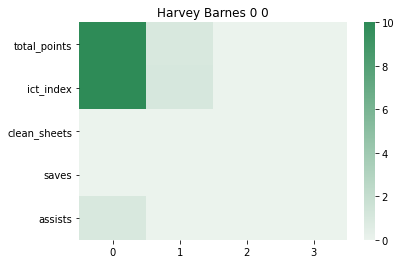

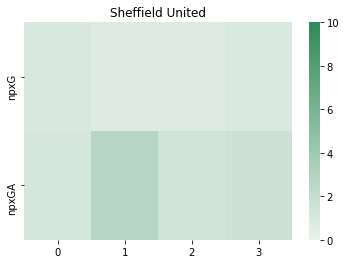

Player in


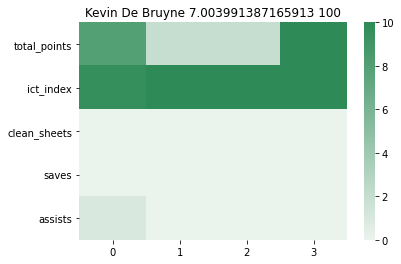

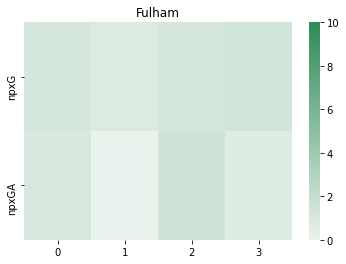

Player out


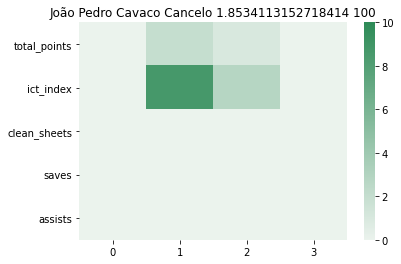

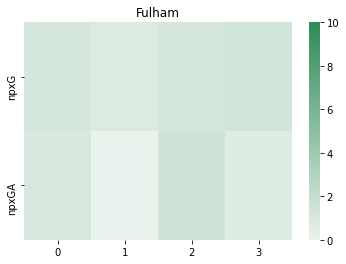

Player in


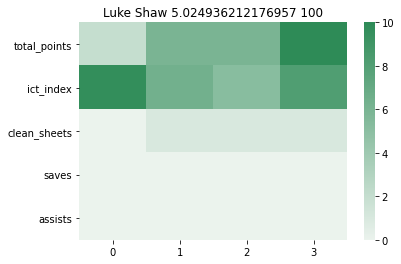

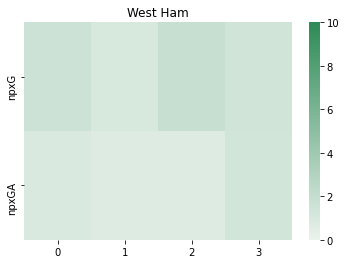

In [3]:
opponent_feature_names = ["npxG","npxGA"]
player_feature_names = ["total_points", "ict_index", "clean_sheets", "saves", "assists"]

agent = Agent(player_feature_names, opponent_feature_names, model_path="./trained_models/player_oppponent_linear_score_model.pt")
await agent.get_data()
agent.update_model()
current_squad, non_squad = await agent.get_new_squad(player_feature_names, opponent_feature_names)

15
Craig Dawson 4.240047534443951 Defender
Andrew Robertson 3.884125391190194 Defender
Ryan Fredericks 1.3630129945729617 Defender
Luke Shaw 5.024936212176957 Defender
Nathan Ferguson 0 Defender
Che Adams 3.699153455989773 Forward
Harry Kane 6.328771441231584 Forward
Keinan Davis 0.8942296088319204 Forward
Lukasz Fabianski 3.617376550636034 Goalkeeper
Rui Pedro dos Santos Patrício 5.489872027104463 Goalkeeper
Riyad Mahrez 6.185691676731892 Midfielder
Bruno Miguel Borges Fernandes 5.609564745321281 Midfielder
Heung-Min Son 5.016981238889272 Midfielder
Kevin De Bruyne 7.003991387165913 Midfielder
Emile Smith Rowe 0.9560983107391267 Midfielder


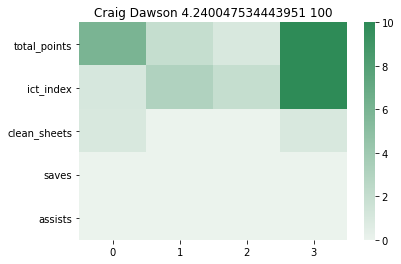

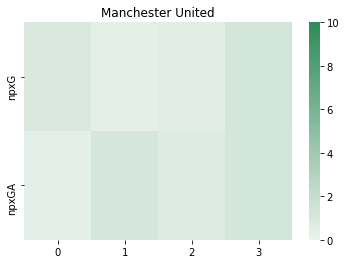

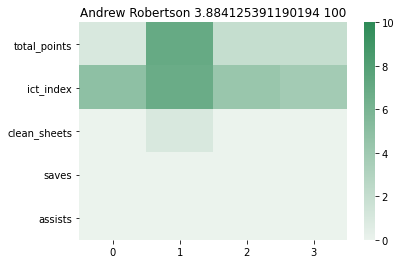

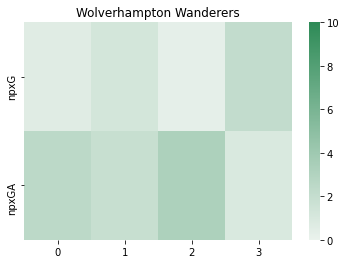

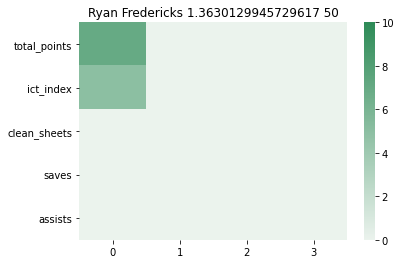

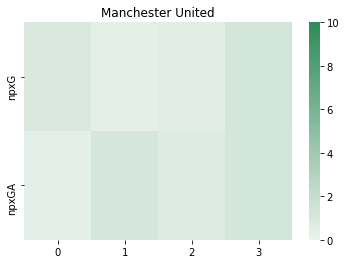

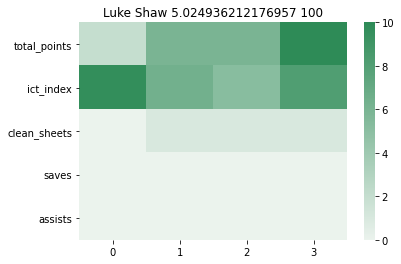

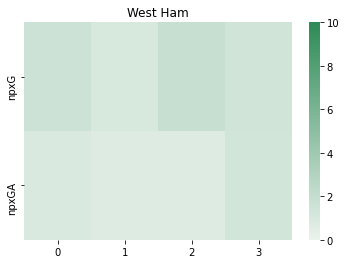

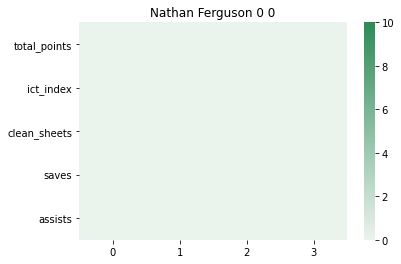

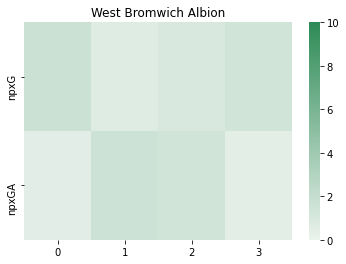

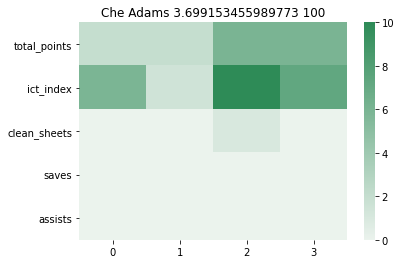

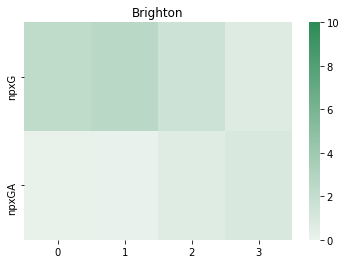

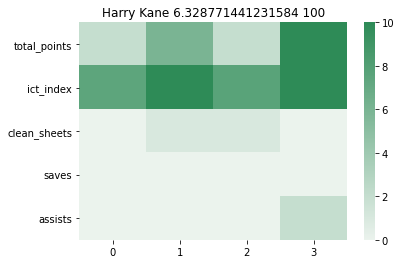

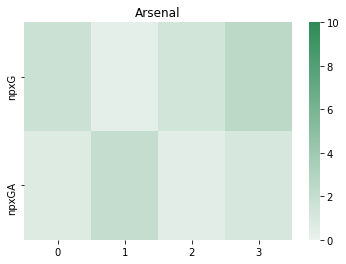

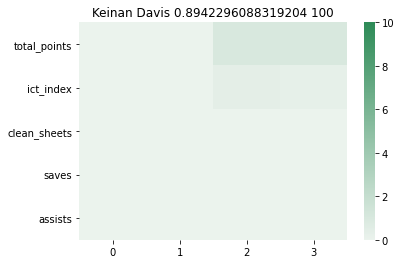

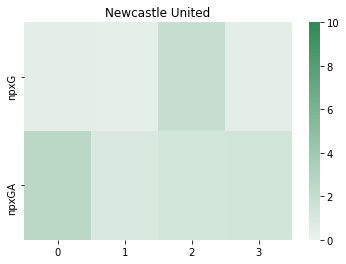

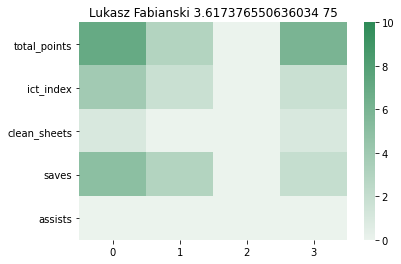

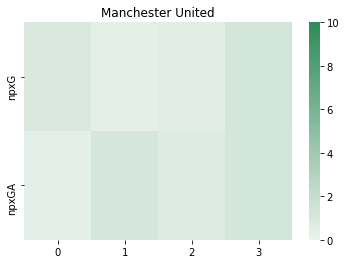

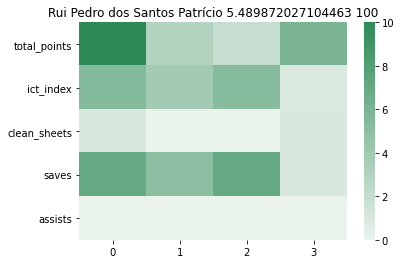

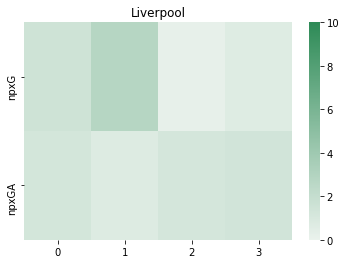

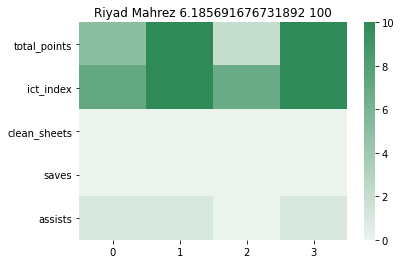

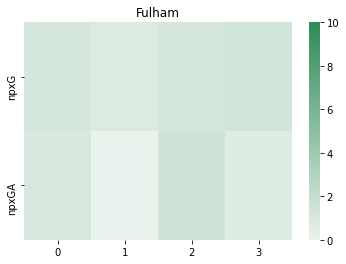

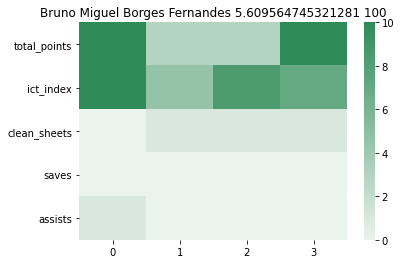

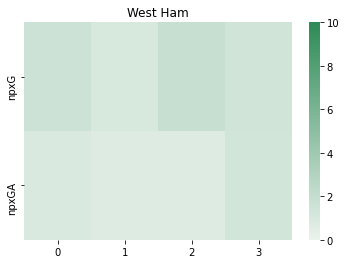

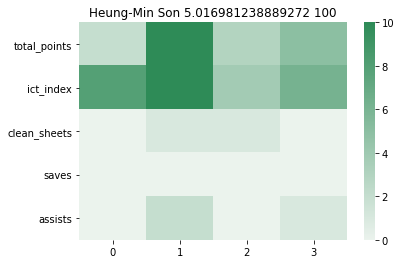

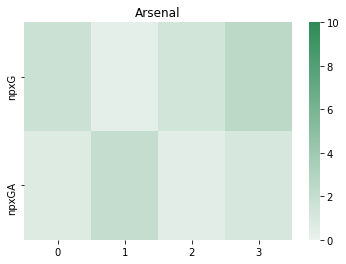

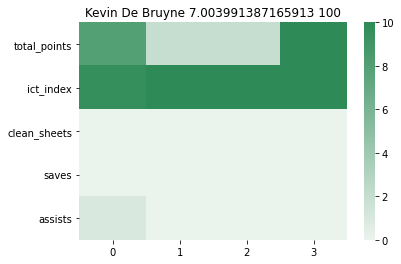

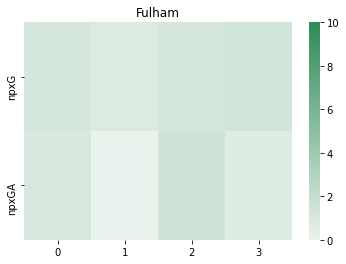

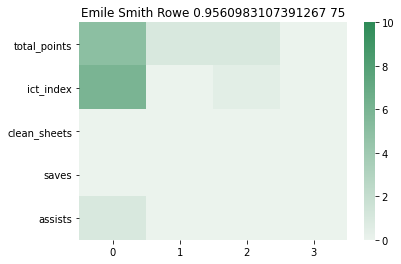

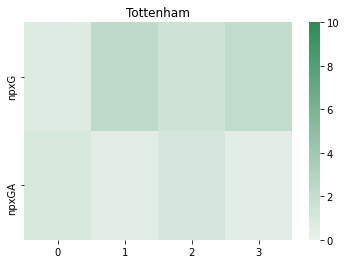

In [17]:
squad = non_squad + current_squad

def knapsack_by_position(squad, position, num_players, max_weight):
    players_in_position = [player for player in squad  if player.position == position ]
    weights, values = [], []
    for player in players_in_position:
        weights.append(player.latest_price)
        values.append(player.predicted_performance)
    return knapsack(weights=weights, values=values, names=players_in_position, max_weight=max_weight, num_players=num_players)

def get_team_by_knapsack(squad, max_weight=1000):
    positions = [('Goalkeeper', 2, 1), ('Defender', 5, 3), ('Midfielder', 5, 4), ('Forward', 3, 2)]
    best_15, best_value = [], -np.inf
    for (position_ordering) in itertools.permutations(positions):
        budget = max_weight
        potential_best_15, potential_best_value = [], 0
        i = 0
        for position, num_players, num_contribution in position_ordering:
            # choose best 11 by knapsack
            # print(position, num_players, num_contribution, num_contribution+i//2)
            best_player_in_position, best_weights_in_position, best_values_in_position = knapsack_by_position(squad, position, num_contribution+i//2, budget)
            budget -= sum(best_weights_in_position)
            potential_best_15.extend(list(best_player_in_position))
            potential_best_value += sum(best_values_in_position)

            # choose cheap filler players
            players_in_position = [player for player in squad if player.position == position]
            players_in_position = sorted(players_in_position, key = lambda x : x.latest_price)[:(num_players-num_contribution-i//2)]
            budget -= sum([player.latest_price for player in players_in_position])
            potential_best_15.extend(players_in_position)        
            i += 1
        
    
        potential_best_15 = sorted(potential_best_15, key = lambda x : x.position)
        if potential_best_value >= best_value:
            best_15 = list(potential_best_15)
            best_value = potential_best_value
    print(len(best_15))
    for player in best_15:
        print(player.name, player.predicted_performance, player.position)
    for player in best_15:    
        player.visualize()


get_team_by_knapsack(squad, 1000)
